[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/pol-is/notebooks/blob/master/020-PCA.ipynb)

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import altair as alt
from textwrap import wrap
from sklearn.neighbors import kneighbors_graph
import numba

import umap

import igraph as ig
import leidenalg

from sklearn.decomposition import PCA

In [2]:
## Set up plots
plt.figure(figsize=(500, 500))
sns.set_context('poster')
sns.set_style('white')
sns.set(font_scale=.7)
sns.set_color_codes()

%matplotlib inline
np.seterr(divide='ignore', invalid='ignore')

{'divide': 'warn', 'over': 'warn', 'under': 'ignore', 'invalid': 'warn'}

### Import raw data && clean up

In [3]:
df = pd.read_csv('./participants-votes.csv',index_col='participant')
df_comments = pd.read_csv('./comments.csv',index_col='comment-id')

In [4]:
df_comments.index = df_comments.index.astype(str)

In [5]:
metadata_fields = ['group-id', 'n-comments', 'n-votes', 
                   'n-agree', 'n-disagree']
val_fields = [c for c in df.columns.values if c not in metadata_fields]

In [6]:
# remove statements (columns) which were moderated out
statements_all_in = sorted(list(df_comments.loc[df_comments["moderated"] > 0].index.array), key = int)

In [7]:
## for a row, count the number of finite values
def count_finite(row):
    finite = np.isfinite(row[val_fields]) # boolean array of whether each entry is finite
    return sum(finite) # count number of True values in `finite`

## REMOVE PARTICIPANTS WITH LESS THAN N VOTES check for each row if the number of finite values >= cutoff
def select_rows(df, threshold=60):
    
    number_of_votes = df.apply(count_finite, axis=1)
    valid = number_of_votes >= threshold
    
    return df[valid]
    
df = select_rows(df)

In [8]:
metadata = df[metadata_fields]
vals = df[val_fields]
# If the participant didn't see the statement, it's a null value, here we fill in the nulls with zeros
vals = vals.fillna(0)
vals = vals.sort_values("participant")

In [9]:
high_variance = [
    "20","26","90"
]

vals_high_variance = vals[high_variance]

statements_consensus = [
    "39","200","83","82","737","64","127","126","66",
]

vals_consensus = vals[statements_consensus]

consensus_disagree = [
    "353","779","720","354"
]

vals_consensus_disagree = vals[consensus_disagree]

statements_opiods = [
    "9",
    "19",
    "11",
    "10",
    "675",
    "753",
    "742",
    "336",
    "329",
    "683",
    "686",
    "894",
    "885",
    "846",
    "688",
    "679",
    "678",
    "676",
]
vals_opiods = vals[statements_opiods]


statements_homelessness = [
    "24","25","34",
#     "45",
    "55",
    "103","105","106","147",
    "160","232","233",
    "404",
#     "535", 
#     "586",
#     "782",
#     "828",
]
vals_homelessness = vals[statements_homelessness]

                              

vals_all_in = vals[statements_all_in]

# Overall stats

How sparse is the dataset? How much agree, how much disagree, how much pass? Zero is 'passed' or 'did not see the comment to vote on it'. 1 is agree, -1 is disagree

In [10]:
melted = vals.melt();
all_votes = melted.count();
by_type = melted["value"].value_counts();
total_possible_votes = all_votes["value"];
total_agrees = by_type[1.0];
total_disagrees = by_type[-1.0];
total_without_vote = by_type[0.0];

print("Dimensions of matrix:", df.shape)
print("Dimensions of matrix:", vals.shape)
print("Total number of possible votes:", total_possible_votes)
print("Total number of agrees:", total_agrees)
print("Total number of disagrees:", total_disagrees)
print("Total without vote:", total_without_vote)
print("Percent sparse: ", total_without_vote / total_possible_votes,"%")

## Make sure to check how many people and votes, relative to the total matrix, you are losing given min vote threshold

Dimensions of matrix: (721, 901)
Dimensions of matrix: (721, 896)
Total number of possible votes: 646016
Total number of agrees: 82841
Total number of disagrees: 29806
Total without vote: 533369
Percent sparse:  0.8256281578165247 %


### Full participants * comments matrix

Some things to notice about the matrix: comments are submitted over time, so participants who do not return will only have voted on the statements which were avialable when they arrived. 

Long horizontal lines: participants who do return show up as a horizontal line sticking out into otherwise blank areas

Blank vertical lines: most likely statements which were moderated out of the conversation. 

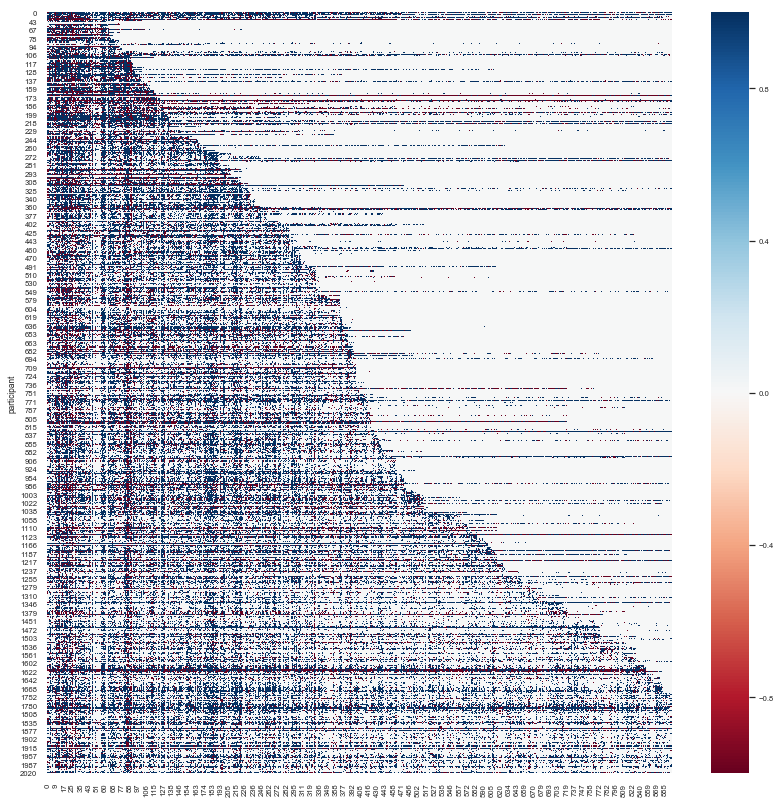

In [11]:
fig, ax = plt.subplots(figsize=(14,14))
sns.heatmap(vals_all_in, center=0, cmap="RdBu", ax=ax)

In [12]:
@numba.njit()
def sparsity_aware_dist(a, b):
    n_both_seen = len(a) - (np.isnan(a) | np.isnan(b)).sum()
    return (n_both_seen - (a == b).sum() + 1) / (n_both_seen + 2)

In [13]:
def polis_pca(dataframe, components):
    pca_object = PCA(n_components=components) ## pca is apparently different, it wants 
    pca_object = pca_object.fit(dataframe.T) ## .T transposes the matrix (flips it)
    coords = pca_object.components_.T ## isolate the coordinates and flip 
    explained_variance = pca_object.explained_variance_ratio_

    return coords, explained_variance

In [14]:
def polis_umap(dataframe, neighbors):
    reducer = umap.UMAP(
        n_neighbors=neighbors,
        metric=sparsity_aware_dist,
        init='random',
        min_dist=0.1,
        spread=1.0,
        local_connectivity=3.0,
    )
    embedding = reducer.fit_transform(dataframe.values)
    # embedding.shape
    
    return embedding

In [15]:
def c(comment, coords):
    fig, ax = plt.subplots(figsize=(7,5))
    plt.sca(ax)
    colorMap = {-1:'#A50026', 1:'#313695', 0:'#FEFEC050'}
    ax.scatter(
        x=coords[:,0],
        y=coords[:,1],
        c=vals[str(comment)].apply(lambda x: colorMap[x]),
        s=10
    )
    ax.set_title("\n".join(wrap(str(comment) + "  " + str(df_comments['comment-body'][comment]))), fontsize=14)
    plt.show()

In [16]:
## Thanks to https://github.com/ciortanmadalina/high_noise_clustering/blob/master/graph-partitioning-louvain.ipynb

def polis_leiden(dataframe, neighbors):
    A = kneighbors_graph(
        dataframe.values, 
        neighbors, 
        mode="connectivity", 
        metric=sparsity_aware_dist, 
        p=3, 
        metric_params=None, 
        include_self=True, 
        n_jobs=None
    )

    sources, targets = A.nonzero()
    weights = A[sources, targets]
    if isinstance(weights, np.matrix): # ravel data
            weights = weights.A1

    g = ig.Graph(directed=False)
    g.add_vertices(A.shape[0])  # each observation is a node
    edges = list(zip(sources, targets))
    g.add_edges(edges)
    g.es['weight'] = weights
    weights = np.array(g.es["weight"]).astype(np.float64)

    part = leidenalg.find_partition(
        g, 
        leidenalg.ModularityVertexPartition
    );

    leidenClusters = np.array(part.membership)
    leidenClustersStr = [str(i) for i in leidenClusters] 

    #df["leiden"] = leidenClustersStr
    
    return leidenClusters

In [17]:
def polis_subconversation(dataframe, comments):
    coords, explained_variance = polis_pca(dataframe, 2)
    print("Explained variance:", explained_variance)

    embedding = polis_umap(dataframe, 10)

    leidenClusters = polis_leiden(dataframe, 8)


    # Show clusters given umap embedding 
    fig, ax = plt.subplots(figsize=(7,5))
    plt.sca(ax)
    ax.scatter(
        x=embedding[:,0],
        y=embedding[:,1],
        c=leidenClusters,
        cmap="tab20",
        s=5
    )
    ax.set_title("Leiden detected communities in UMAP space", fontsize=14)


    # Show clusters given pca embedding 
    fig, ax = plt.subplots(figsize=(7,5))
    plt.sca(ax)
    ax.scatter(
        x=coords[:,0],
        y=coords[:,1],
        c=leidenClusters,
        cmap="tab20",
        s=5
    )

    ax.set_title("Leiden detected communities in PCA space", fontsize=14)
    plt.show()
    
    # number of votes in pca space
    plt.figure(figsize=(7, 5), dpi=80)
    plt.scatter(
        x=coords[:,0], 
        y=coords[:,1], 
        c=metadata['n-votes'],
        cmap="magma_r",
        s=5
    )
    plt.colorbar()
    
    # when did the participant show up? index
    plt.figure(figsize=(7, 5), dpi=80)
    plt.scatter(
        x=coords[:,0], 
        y=coords[:,1], 
        c=metadata.index,
        cmap="magma_r",
        s=5
    )
    plt.colorbar()
    
    
    # PCA for COMMENTS
    
    coords, explained_variance = polis_pca(dataframe.T, 2)
    
    plt.figure(figsize=(7, 5), dpi=80)
    plt.scatter(
        x=coords[:,0], 
        y=coords[:,1], 
#         c=,
        cmap="magma_r",
        s=5
    )
    
    

#     plt.colorbar()
    
#     # Show clustermap
#     dataframe['leiden_cluster_assignments'] = leidenClusters
#     clusters_by_comments_means = dataframe.groupby('leiden_cluster_assignments').agg('mean')

#     #sns.heatmap(clusters_by_comments_means, cmap="RdYlBu")
#     sns.clustermap(clusters_by_comments_means, cmap="RdYlBu", figsize=(15,15))

    for x in comments:
        c(x, coords)
        c(x, embedding)
        

In [18]:
def polis_heatmap(__dataframe):
    leidenClusters = polis_leiden(__dataframe, 8)

    # Show clustermap
    __dataframe['leiden_cluster_assignments'] = leidenClusters
    clusters_by_comments_means = __dataframe.groupby('leiden_cluster_assignments').agg('mean').T

    index_to_label = df_comments['comment-body'].to_dict() # {index: label}

    clustergrid = sns.clustermap(clusters_by_comments_means, cmap="RdBu", figsize=(10,10), )

    ax = clustergrid.ax_heatmap
    new_labels = [index_to_label[str(idx._text)] for idx in ax.get_yticklabels()] # [ label0, label1, label2, ...]
    ax.set_yticklabels(new_labels, rotation=0, fontsize=10)

# Is the space explained by how much people vote?

In this chart, we take the PCA coordinates and color the participant locations by the number of total votes. Hopefully, it looks random. If it doesn't, we might imagine the following scenario:

1. 1000 people vote, and there are very few controversial statements. They do not return.
2. 1 person submits a statement which is incredibly controversial. 
3. 1000 more people vote, the space begins to take on structure, PCA is closely linked to vote count.

We know this scenario - that voters don't see controversial comments - happens. Polis mitigates in two ways:
* polis eliminates participants who don't vote at least 7 times from the analysis
* polis shows several highly controversial comments (large egeinvalue) in the first 10 comments participants see

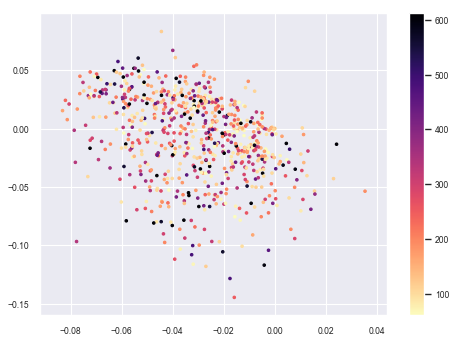

In [19]:
coords, embedding = polis_pca(vals_all_in, 2)

plt.figure(figsize=(7, 5), dpi=80)
plt.scatter(
    x=coords[:,0], 
    y=coords[:,1], 
    c=metadata['n-votes'],
    cmap="magma_r",
    s=5
)
plt.colorbar()

# High Variance

In [20]:
#polis_subconversation(vals_all_in, high_variance)

# Consensus

In [21]:
#polis_subconversation(vals_all_in, statements_consensus)

# Opiods

In [22]:
# polis_heatmap(vals_opiods)

In [24]:
# polis_subconversation(vals_opiods, statements_opiods)

# Homelessness

[Text(0.5, 0, 'Homelessness is for the nonprofit sector to deal with, not government.'),
 Text(1.5, 0, 'No family should be homeless in Bowling Green / Warren County, and it is up to our officials to make sure they have options for shelter.'),
 Text(2.5, 0, 'I would like to see more aid for the homeless whether: tiny house park, health clinic, rehabilitation, job readiness sources.'),
 Text(3.5, 0, 'The homeless population is getting out of hand. We need to find better methods for curtailing and rehabing and keeping them off the streets.'),
 Text(4.5, 0, 'Every school has 1-9% homeless people. This is for the government to deal with via economic policy.  Not sending to a NGO or giving a shanty'),
 Text(5.5, 0, 'If city eliminates homelessness via occupational taxes, employers of homeless people need to reimburse city via special occ. tax penalty'),
 Text(6.5, 0, 'Homeless people deserve full size places like studio apartments.  Not tiny homes like a smurf would desire in a tiny house p

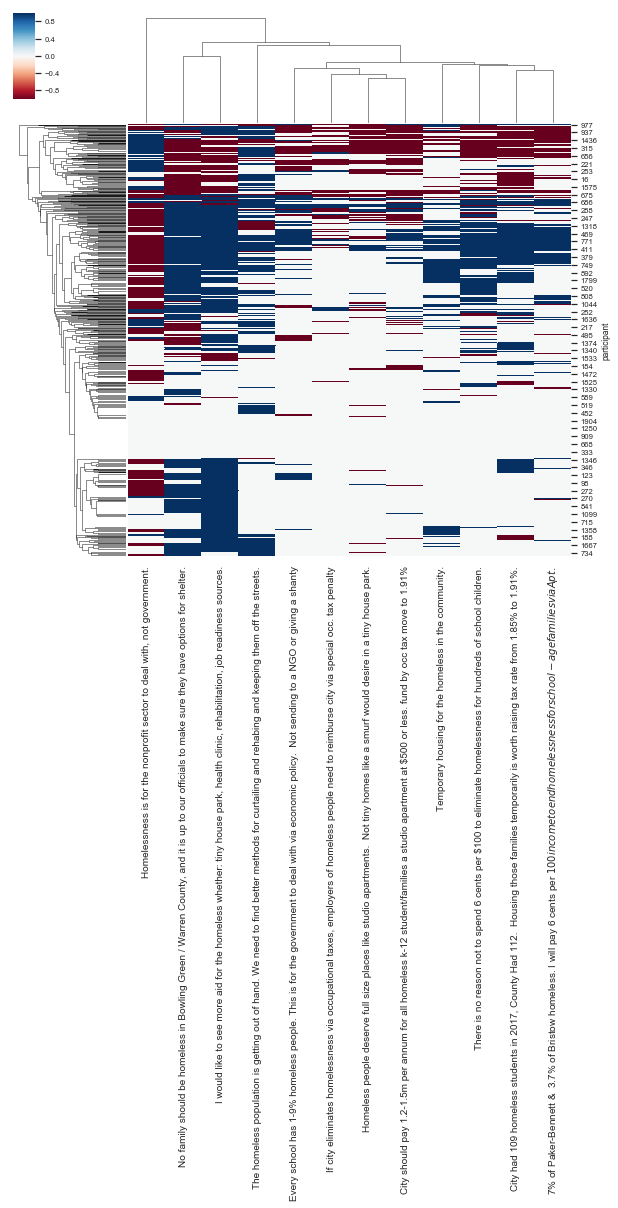

In [25]:
#     leidenClusters = polis_leiden(__dataframe, 8)

    # Show clustermap
#     __dataframe['leiden_cluster_assignments'] = leidenClusters

index_to_label = df_comments['comment-body'].to_dict() # {index: label}

clustergrid = sns.clustermap(vals_homelessness, cmap="RdBu", figsize=(10,10), )

ax = clustergrid.ax_heatmap
new_labels = [index_to_label[str(idx._text)] for idx in ax.get_xticklabels()] # [ label0, label1, label2, ...]
ax.set_xticklabels(new_labels, rotation=90, fontsize=10)

In [ ]:
# polis_heatmap(vals_homelessness)

In [27]:
#  polis_subconversation(vals_homelessness, statements_homelessness)

# All

In [ ]:
# coords, explained_variance = polis_pca(vals_all_in, 2)
# print("Explained variance:", explained_variance)

# embedding = polis_umap(vals_all_in, 4)

# leidenClusters = polis_leiden(vals_all_in, 8)

# # Show clusters given umap embedding 
# fig, ax = plt.subplots(figsize=(7,5))
# plt.sca(ax)
# ax.scatter(
#     x=embedding[:,0],
#     y=embedding[:,1],
#     c=leidenClusters,
#     cmap="tab20",
#     s=5
# )

# ax.set_title("Leiden detected communities in UMAP space", fontsize=14)
# plt.show()

# for x in statements_all_in:
#     if int(x) < 5:
#         c(x, coords)
#         c(x, embedding)

In [ ]:
# leidenClusters = polis_leiden(vals_opiods, 8)

# # Show clustermap
# vals_opiods['leiden_cluster_assignments'] = leidenClusters
# clusters_by_comments_means = vals_opiods.groupby('leiden_cluster_assignments').agg('mean').T

In [ ]:
# index_to_label = df_comments['comment-body'].to_dict() # {index: label}

# clustergrid = sns.clustermap(clusters_by_comments_means, cmap="RdYlBu", figsize=(15,15), )

# ax = clustergrid.ax_heatmap
# new_labels = [index_to_label[str(idx._text)] for idx in ax.get_yticklabels()] # [ label0, label1, label2, ...]
# ax.set_yticklabels(new_labels, rotation=0, fontsize=16)